In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [3]:
import numpy as np
import os 
from os import walk

def load_safari(folder):

    mypath = os.path.join("./mount/My Drive/Colab Notebooks/GDLgon/data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal

In [4]:
import torch
import torch.nn as nn

class View(nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
    def forward(self,x):
        return x.view(*self.shape)

In [5]:
class D(nn.Module):
    def __init__(self,dim_latent=200):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        self.dim_latent = dim_latent
       # 신경망 레이어 정의
        self.model = nn.Sequential(
            #(-1,1,28,28)
            nn.Conv2d(1, 64, kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,14,14)
            
            nn.Conv2d(64, 64, kernel_size=5, stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,7,7)

            nn.Conv2d(64, 128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,4,4)
            
            nn.Conv2d(128, 128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,4,4)

            View((-1,128*4*4)),
            nn.Linear(128*4*4, 1),
        )


        # 손실 함수 생성
        self.loss_function = self.wasserstein
        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0008)
    def forward(self,x):
        return self.model(x)

    def wasserstein(self,y_pred,y_true):
        return torch.mean(y_true*y_pred)

    def train(self,x_batch,label):
        self.optimiser.zero_grad()
        y_pred = self.forward(x_batch)
        
        loss = self.loss_function(y_pred,label)
        loss.backward()
        self.optimiser.step()
        return loss
        ## weight clipping하면 clipped grad 어떻게 계산되지?

In [6]:
class G(nn.Module):
    def __init__(self,dim_latent=100):
        # 파이토치 부모 클래스 초기화
        super().__init__()
       # 신경망 레이어 정의
        self.dim_latent = dim_latent
        self.model = nn.Sequential(
            #(-1,100)
            nn.Linear(self.dim_latent,64*7*7),
            View((-1,64,7,7)),
            #(-1,3136)
            #(-1,64,7,7)
            
            nn.ConvTranspose2d(64,64,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),            
            #(-1,64,14,14)

            nn.ConvTranspose2d(64,128,5,padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,14,14)

            nn.ConvTranspose2d(128,64,6,stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,28,28)

            nn.ConvTranspose2d(64,1,5,padding=2),
            nn.Tanh(),
            #(-1,1,28,28)

        )


        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0004)
    def forward(self,x):
        return self.model(x)

    def train(self,D,latent_batch,label):
    
        self.optimiser.zero_grad()
        ## D.optimiser.zero_grad()  필요없음
        g_output = self.forward(latent_batch)
        d_output = D(g_output)

        loss = D.loss_function(d_output,label)
        loss.backward()
        self.optimiser.step()
        # D(x_input,1) ->D학습
        # D(G(latent), 0) ->D학습
        # D(G(latent),1) ->G학습
        return loss


In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class MyDataset(Dataset):
    def __init__(self,foldername='camel'):
        (self.x_train, self.y_train) =load_safari(foldername)
    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        
        x_train = self.x_train.transpose((0,3,1,2))
        #return torch.FloatTensor(x_train[idx])
        return torch.cuda.FloatTensor(x_train[idx])
data_loader = DataLoader(MyDataset(), batch_size=64, shuffle=True,generator=torch.Generator(device='cuda'))
#data_loader = DataLoader(MyDataset(), batch_size=64, shuffle=True)


In [9]:
%%time 

d = D()
g= G()
d.to(device)
g.to(device)

d_loss_hist = []
g_loss_hist =[]

for epoch in range(1, 101):
    for i,x_input in enumerate(data_loader):

        pass
        label = torch.ones((x_input.shape[0],1))
        fake_label = -torch.ones((x_input.shape[0],1))
        d_loss=d.train(x_input,label)
        d_fake_loss=d.train(g(torch.randn(64,100)).detach(),fake_label)
        with torch.no_grad():
            for param in d.parameters():
                param.clamp_(-0.01, 0.01)
        
        total_d_loss =(d_loss.item()+d_fake_loss.item())/2
        d_loss_hist.append(total_d_loss)
        if (i%5==4):
            g_loss=g.train(d,torch.randn(64,100),label)
            g_loss_hist.append(g_loss.item())
        if i % 600 == 599:
            print(f"Epoch {epoch}: d_loss = {total_d_loss:.9f}  g loss={g_loss.item():.9f}")


Epoch 1: d_loss = -0.199005447  g loss=0.189546645
Epoch 1: d_loss = -0.199213803  g loss=0.192076415
Epoch 2: d_loss = -0.121684678  g loss=0.087178439
Epoch 2: d_loss = -0.197244957  g loss=0.188774064
Epoch 3: d_loss = -0.173786804  g loss=0.182859361
Epoch 3: d_loss = -0.170926027  g loss=0.172722578
Epoch 4: d_loss = -0.192720428  g loss=0.187169880
Epoch 4: d_loss = -0.190747268  g loss=0.187039733
Epoch 5: d_loss = -0.129381768  g loss=0.170105621
Epoch 5: d_loss = -0.190876544  g loss=0.186566055
Epoch 6: d_loss = -0.192181505  g loss=0.187279493
Epoch 6: d_loss = -0.173947290  g loss=0.174387127
Epoch 7: d_loss = -0.168921731  g loss=0.169751614
Epoch 7: d_loss = -0.192466617  g loss=0.186778426
Epoch 8: d_loss = -0.162722848  g loss=0.162369385
Epoch 8: d_loss = -0.179632097  g loss=0.180145353
Epoch 9: d_loss = -0.132777393  g loss=0.164684132
Epoch 9: d_loss = -0.189541407  g loss=0.185876086
Epoch 10: d_loss = -0.111361369  g loss=0.135893852
Epoch 10: d_loss = -0.16290338

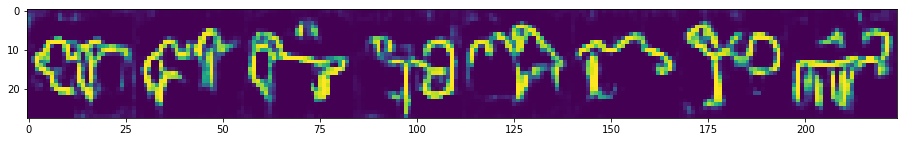

In [10]:
import matplotlib.pyplot as plt

fake_pred = g.forward(torch.randn(8,100)).detach().cpu().numpy() #(8,1,28,28)
fake_pred = fake_pred.transpose(0,2,3,1) #(8,28,28,1)
fake_8img = fake_pred.transpose(1,0,2,3).reshape(28,-1)
plt.figure(figsize=(16,2))
plt.imshow(fake_8img)

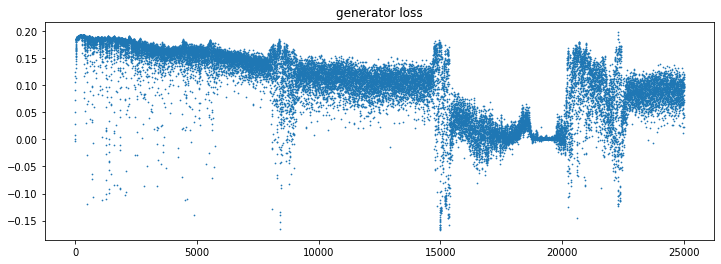

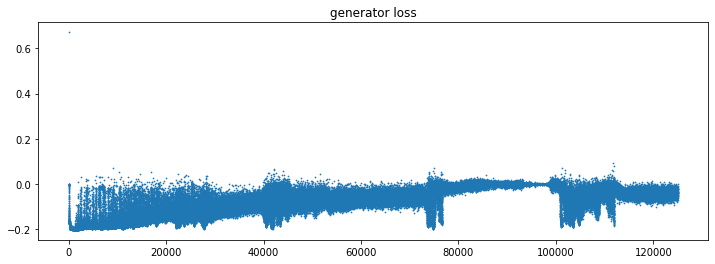

In [11]:
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()
visualize(g_loss_hist)
visualize(d_loss_hist)

In [12]:
torch.save(d.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_d_camel_trained.pth")
torch.save(g.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_g_camel_trained.pth")

In [13]:
%%time 

d = D()
g= G()
d.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_d_camel_trained.pth"))
g.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_g_camel_trained.pth"))
d.to(device)
g.to(device)

d_loss_hist = []
g_loss_hist =[]

for epoch in range(1, 101):
    for i,x_input in enumerate(data_loader):

        pass
        label = torch.ones((x_input.shape[0],1))
        fake_label = torch.ones((x_input.shape[0],1))
        d_loss=d.train(x_input,label)
        d_fake_loss=d.train(g(torch.randn(64,100)).detach(),fake_label)
        with torch.no_grad():
            for param in d.parameters():
                param.clamp_(-0.01, 0.01)
        
        total_d_loss =(d_loss.item()+d_fake_loss.item())/2
        d_loss_hist.append(total_d_loss)
        if (i%5==4):
            g_loss=g.train(d,torch.randn(64,100),label)
            g_loss_hist.append(g_loss.item())
        if i % 600 == 599:
            print(f"Epoch {epoch}: d_loss = {total_d_loss:.9f}  g loss={g_loss.item():.9f}")


Epoch 1: d_loss = -0.279843614  g loss=-0.258193970
Epoch 1: d_loss = -0.280007169  g loss=-0.259114265
Epoch 2: d_loss = -0.280130163  g loss=-0.259402484
Epoch 2: d_loss = -0.280316174  g loss=-0.258707106
Epoch 3: d_loss = -0.280314907  g loss=-0.259296328
Epoch 3: d_loss = -0.280190229  g loss=-0.259329021
Epoch 4: d_loss = -0.280096710  g loss=-0.258912921
Epoch 4: d_loss = -0.279890046  g loss=-0.258518964
Epoch 5: d_loss = -0.280289590  g loss=-0.258792102
Epoch 5: d_loss = -0.280217901  g loss=-0.259338349
Epoch 6: d_loss = -0.280262426  g loss=-0.258646965
Epoch 6: d_loss = -0.279762819  g loss=-0.259496719
Epoch 7: d_loss = -0.280101806  g loss=-0.258498222
Epoch 7: d_loss = -0.280007347  g loss=-0.259295642
Epoch 8: d_loss = -0.280558825  g loss=-0.258772731
Epoch 8: d_loss = -0.280224979  g loss=-0.259077370
Epoch 9: d_loss = -0.280094892  g loss=-0.258424640
Epoch 9: d_loss = -0.280418396  g loss=-0.259180635
Epoch 10: d_loss = -0.279956758  g loss=-0.258852363
Epoch 10: d

KeyboardInterrupt: ignored

In [14]:
torch.save(d.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_d_camel_trained_epoch140.pth")
torch.save(g.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_g_camel_trained_epoch140.pth")

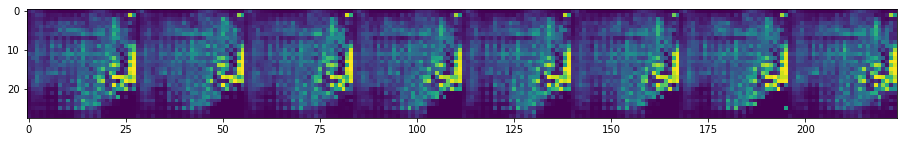

In [15]:
import matplotlib.pyplot as plt

fake_pred = g.forward(torch.randn(8,100)).detach().cpu().numpy() #(8,1,28,28)
fake_pred = fake_pred.transpose(0,2,3,1) #(8,28,28,1)
fake_8img = fake_pred.transpose(1,0,2,3).reshape(28,-1)
plt.figure(figsize=(16,2))
plt.imshow(fake_8img)